In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from functools import partial
from pathlib import Path
from multiprocessing import Pool
import os
import shutil
import numpy as np
import pandas as pd
import librosa
from scipy.io import wavfile
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F
from fastai.basic_data import DatasetType


def read_file(filename, path='', sample_rate=None, trim=False):
    ''' Reads in a wav file and returns it as an np.float32 array in the range [-1,1] '''
    filename = Path(path) / filename
    file_sr, data = wavfile.read(filename)
    if data.dtype == np.int16:
        data = np.float32(data) / np.iinfo(np.int16).max
    elif data.dtype != np.float32:
        raise OSError('Encounted unexpected dtype: {}'.format(data.dtype))
    if sample_rate is not None and sample_rate != file_sr:
        if len(data) > 0:
            data = librosa.core.resample(data, file_sr, sample_rate, res_type='kaiser_fast')
        file_sr = sample_rate
    if trim and len(data) > 1:
        data = librosa.effects.trim(data, top_db=40)[0]
    return data, file_sr


def write_file(data, filename, path='', sample_rate=44100):
    ''' Writes a wav file to disk stored as int16 '''
    filename = Path(path) / filename
    if data.dtype == np.int16:
        int_data = data
    elif data.dtype == np.float32:
        int_data = np.int16(data * np.iinfo(np.int16).max)
    else:
        raise OSError('Input datatype {} not supported, use np.float32'.format(data.dtype))
    wavfile.write(filename, sample_rate, int_data)


def load_audio_files(path, filenames=None, sample_rate=None, trim=False):
    '''
    Loads in audio files and resamples if necessary.
    
    Args:
        path (str or PosixPath): directory where the audio files are located
        filenames (list of str): list of filenames to load. if not provided, load all 
                                 files in path
        sampling_rate (int): if provided, audio will be resampled to this rate
        trim (bool): 
    
    Returns:
        list of audio files as numpy arrays, dtype np.float32 between [-1, 1]
    '''
    path = Path(path)
    if filenames is None:
        filenames = sorted(list(f.name for f in path.iterdir()))
    files = []
    for filename in tqdm(filenames, unit='files'):
        data, file_sr = read_file(filename, path, sample_rate=sample_rate, trim=trim)
        files.append(data)
    return files
    
        
def _resample(filename, src_path, dst_path, sample_rate=16000, trim=True):
    data, sr = read_file(filename, path=src_path, sample_rate=sample_rate, trim=trim)
    write_file(data, filename, path=dst_path, sample_rate=sample_rate)
    

def resample_path(src_path, dst_path, **kwargs):
    transform_path(src_path, dst_path, _resample, **kwargs)    
    

def _to_mono(filename, dst_path):
    data, sr = read_file(filename)
    if len(data.shape) > 1:
        data = librosa.core.to_mono(data.T) # expects 2,n.. read_file returns n,2
    write_file(data, dst_path/filename.name, sample_rate=sr)


def convert_to_mono(src_path, dst_path, processes=None):
    src_path, dst_path = Path(src_path), Path(dst_path)
    os.makedirs(dst_path, exist_ok=True)
    filenames = list(src_path.iterdir())
    convert_fn = partial(_to_mono, dst_path=dst_path)
    with Pool(processes=processes) as pool:
        with tqdm(total=len(filenames), unit='files') as pbar:
            for _ in pool.imap_unordered(convert_fn, filenames):
                pbar.update()
                
                
def transform_path(src_path, dst_path, transform_fn, fnames=None, processes=None, delete=False, **kwargs):
    src_path, dst_path = Path(src_path), Path(dst_path)
    if dst_path.exists() and delete:
        shutil.rmtree(dst_path)
    os.makedirs(dst_path, exist_ok=True)
    
    _transformer = partial(transform_fn, src_path=src_path, dst_path=dst_path, **kwargs)
    if fnames is None:
        fnames = [f.name for f in src_path.iterdir()]
    with Pool(processes=processes) as pool:
        with tqdm(total=len(fnames), unit='files') as pbar:
            for _ in pool.imap_unordered(_transformer, fnames):
                pbar.update()


class RandomPitchShift():
    def __init__(self, sample_rate=22050, max_steps=3):
        self.sample_rate = sample_rate
        self.max_steps = max_steps
    def __call__(self, x):
        n_steps = np.random.uniform(-self.max_steps, self.max_steps)
        x = librosa.effects.pitch_shift(x, sr=self.sample_rate, n_steps=n_steps)
        return x


def _make_transforms(filename, src_path, dst_path, tfm_fn, sample_rate=22050, n_tfms=5):
    data, sr = read_file(filename, path=src_path)
    fn = Path(filename)
    # copy original file 
    new_fn = fn.stem + '_00.wav'
    write_file(data, new_fn, path=dst_path, sample_rate=sample_rate)
    # make n_tfms modified files
    for i in range(n_tfms):
        new_fn = fn.stem + '_{:02d}'.format(i+1) + '.wav'
        if not (dst_path/new_fn).exists():
            x = tfm_fn(data)
            write_file(x, new_fn, path=dst_path, sample_rate=sample_rate)


def pitch_shift_path(src_path, dst_path, max_steps, sample_rate, n_tfms=5):
    pitch_shifter = RandomPitchShift(sample_rate=sample_rate, max_steps=max_steps)
    transform_path(src_path, dst_path, _make_transforms, 
                   tfm_fn=pitch_shifter, sample_rate=sample_rate, n_tfms=n_tfms)
    
    
def rand_pad_crop(signal, pad_start_pct=0.1, crop_end_pct=0.5):
    r_pad, r_crop = np.random.rand(2)
    pad_start = int(pad_start_pct * r_pad * signal.shape[0])
    crop_end  = int(crop_end_pct * r_crop * signal.shape[0]) + 1
    return F.pad(signal[:-crop_end], (pad_start, 0), mode='constant')


def get_transforms(min_len=2048):
    def _train_tfm(x):
        x = rand_pad_crop(x)
        if x.shape[0] < min_len:
            x = F.pad(x, (0, min_len - x.shape[0]), mode='constant')
        return x
    
    def _valid_tfm(x):
        if x.shape[0] < min_len:
            x = F.pad(x, (0, min_len - x.shape[0]), mode='constant')
        return x
  
    return [_train_tfm],[_valid_tfm]


def save_submission(learn, filename, tta=False):
    fnames = [Path(f).name for f in learn.data.test_ds.x.items]
    get_predsfn = learn.TTA if tta else learn.get_preds
    preds = get_predsfn(ds_type=DatasetType.Test)[0]
    top_3 = np.array(learn.data.classes)[np.argsort(-preds, axis=1)[:, :3]]
    labels = [' '.join(list(x)) for x in top_3]
    df = pd.DataFrame({'fname': fnames, 'label': labels})
    df.to_csv(filename, index=False)
    return df


def precision(y_pred, y_true, thresh:float=0.2, eps:float=1e-9, sigmoid:bool=True):
    "Computes the f_beta between preds and targets"
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    return prec.mean()


def recall(y_pred, y_true, thresh:float=0.2, eps:float=1e-9, sigmoid:bool=True):
    "Computes the f_beta between preds and targets"
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    rec = TP/(y_true.sum(dim=1)+eps)
    return rec.mean()

In [0]:
!unzip 'audiodata.zip' 
# !pip install utils

In [0]:
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
# from utils import read_file, transform_path

In [0]:
# !mkdir audio_data/train
# !mv audio_data/Actor_01/* audio_data/train/

In [0]:
# rm -rf audio_data/

In [98]:
!zip -r audio_data_update.zip audio_data

updating: audio_data/ (stored 0%)
  adding: audio_data/train/ (stored 0%)
  adding: audio_data/train/03-01-08-02-01-01-04.wav (deflated 60%)
  adding: audio_data/train/03-01-03-02-02-02-04.wav (deflated 54%)
  adding: audio_data/train/03-01-08-01-02-02-15.wav (deflated 64%)
  adding: audio_data/train/03-01-07-02-01-02-16.wav (deflated 61%)
  adding: audio_data/train/03-01-01-01-02-01-11.wav (deflated 69%)
  adding: audio_data/train/03-01-03-01-01-02-05.wav (deflated 68%)
  adding: audio_data/train/03-01-05-02-02-01-02.wav (deflated 55%)
  adding: audio_data/train/03-01-02-01-01-02-02.wav (deflated 68%)
  adding: audio_data/train/03-01-02-02-02-01-08.wav (deflated 66%)
  adding: audio_data/train/03-01-08-02-02-01-19.wav (deflated 60%)
  adding: audio_data/train/03-01-02-01-02-01-04.wav (deflated 65%)
  adding: audio_data/train/03-01-03-02-01-01-07.wav (deflated 48%)
  adding: audio_data/train/03-01-02-02-01-01-14.wav (deflated 79%)
  adding: audio_data/train/03-01-08-02-02-01-18.wav (de

In [0]:
# !rm -rf audio_data/Actor_*
# !mkdir -p image_data1/train image_data1/test

In [100]:
# these folders must be in place
TRAIN_AUDIO_PATH = (f'{"audio_data/train/"}')
VALID_AUDIO_PATH = (f'{"audio_data/test/"}')
TRAIN_IMAGE_PATH = (f'{"image_data1/train/"}')
VALID_IMAGE_PATH = (f'{"image_data1/test/"}')
TRAIN_AUDIO_PATH, VALID_IMAGE_PATH

('audio_data/train/', 'image_data1/test/')

In [40]:
train_actor_fnames = []
valid_actor_fnames = []
for i in range(len(TRAIN_AUDIO_PATH)):
  for file in os.listdir(Path(TRAIN_AUDIO_PATH[i])):
    train_actor_fnames.append(file)
for i in range(0,4):
  for file in os.listdir(Path(VALID_AUDIO_PATH[i])):
    valid_actor_fnames.append(file)
print(len(train_actor_fnames),len(valid_actor_fnames))


1200 240


In [0]:
# !rm -rf image_data/train/*-21.png
# !rm -rf image_data/train/*-22.png
# !rm -rf image_data/train/*-23.png
# !rm -rf image_data/train/*-24.png

In [0]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    filename = f'{src_path}{fname}'
#     print(filename)
    x, sample_rate = librosa.load(filename)
    f = list(fname)
    rank = int(f[7])
    if rank>1:
      rank-=1
    f[7] = str(rank)
    fname = "".join(f)
    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
#     dst_fname = dst_path / (fname[:-4] + '.png')
    dst_fname = f'{dst_path}{fname[:-4]}{".png"}'
    plt.imsave(dst_fname, mel_spec_db)

In [0]:
# !rm -rf image_data1
# !mkdir image_data/train

In [0]:
fn = "03-01-01-01-01-01-03.wav"
log_mel_spec_tfm(fn, TRAIN_AUDIO_PATH, Path('.'))
img = plt.imread(fn[:-4] + '.png')
plt.imshow(img, origin='lower');

# /content/audio_data/train/03-01-01-01-01-01-03.wav

In [124]:
for file in os.listdir(TRAIN_AUDIO_PATH):
  log_mel_spec_tfm(file,TRAIN_AUDIO_PATH,TRAIN_IMAGE_PATH)
  

FileNotFoundError: ignored

In [0]:
|for file in os.listdir(VALID_AUDIO_PATH):
  log_mel_spec_tfm(file,VALID_AUDIO_PATH,VALID_IMAGE_PATH)

In [0]:
import fastai
from fastai.vision import *
from fastai.basics import *

In [0]:
def func(file_path): return str(file_path)[-17]
src = (ImageList.from_folder('image_data')
            .split_by_folder('train','test')
            .label_from_func(func))
tfms = None # or tfms=None if none are needed
size=(40,265)# or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=10, num_workers=16).normalize()

In [75]:
data.c, data.classes

(8, ['1', '2', '3', '4', '5', '6', '7', '8'])

In [76]:
xs, ys = data.one_batch()
xs.shape, ys.shape


(torch.Size([10, 3, 40, 265]), torch.Size([10]))

In [77]:
xs.min(), xs.max(), xs.mean(), xs.std()

(tensor(0.0039), tensor(0.9922), tensor(0.3305), tensor(0.1940))

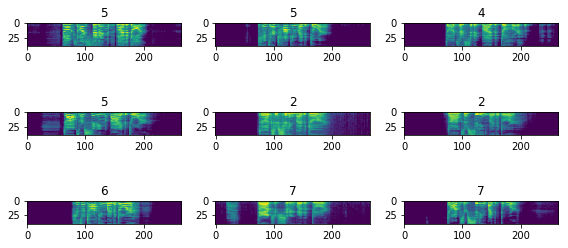

In [78]:
data.show_batch(3, figsize=(8,4), hide_axis=False)

In [83]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(3)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 115621284.83it/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.121181,1.906765,0.327801,00:10
1,1.735767,1.853057,0.319502,00:10
2,1.428330,1.793769,0.336100,00:10


In [84]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


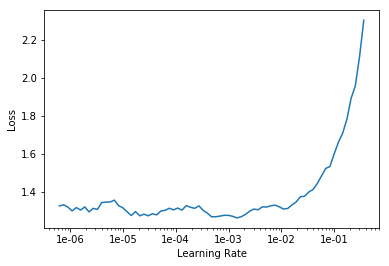

In [85]:
learn.recorder.plot()

In [86]:
learn.unfreeze()
learn.fit_one_cycle(3,max_lr=slice(2e-4,2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.361318,1.810291,0.319502,00:10
1,1.296839,1.849425,0.319502,00:10
2,1.077893,1.827980,0.336100,00:10


In [87]:
learn.fit_one_cycle(10,max_lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.000270,1.852242,0.373444,00:10
1,1.005226,1.878168,0.369295,00:10
2,1.197173,2.003116,0.385892,00:10
3,1.121832,1.747039,0.414938,00:10
4,0.953477,1.733308,0.439834,00:10
5,0.803431,1.956043,0.402490,00:10
6,0.581448,1.739945,0.456432,00:10
7,0.479127,1.736211,0.468880,00:10
8,0.367322,1.727362,0.464730,00:10
9,0.361962,1.762634,0.456432,00:10


In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

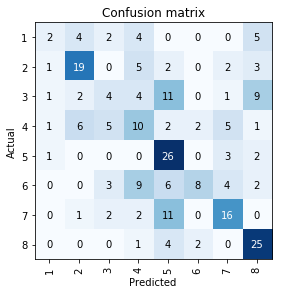

In [89]:
interp.plot_confusion_matrix()